In [21]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [22]:
# read the main data set
df=pd.read_csv('estimation_file.csv',
                    encoding='utf-8')


/Users/rianajawad/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [24]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [25]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

In [26]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [27]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [28]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [29]:
# check the data
df.head()

Unnamed: 0   CBSA          UPT          VRM  \
ID                       Year                                                
Akron, OH Metro Area-Bus 2002           0  10420  5226385.660  4026372.388   
                         2003           1  10420  5395901.888  3976568.624   
                         2004           2  10420  5907162.281  4315392.555   
                         2005           3  10420  6013680.881  4053011.065   
                         2006           4  10420  6070797.419  3994786.013   

                                   UPT_ADJ      VRM_ADJ      VRH_ADJ  \
ID                       Year                                          
Akron, OH Metro Area-Bus 2002  5226385.660  4026372.388  270506.6928   
                         2003  5395901.888  3976568.624  270398.3688   
                         2004  5907162.281  4315392.555  597239.8605   
                         2005  6013680.881  4053011.065  281367.9792   
                         2006  6070797.419  3994786.013  281536.7841   

                               FARE_TOTAL  FARE_per_UPT  AREALANDPT  \
ID                       Year                                         
Akron, OH Metro Area-Bus 2002    660887.0      0.126452   744634347   
                         2003   2568502.0      0.476010   744634347   
                         2004   2524882.0      0.427427   744634347   
                         2005   3022880.0      0.502667   744634347   
                         2006   3163036.0      0.521025   744634347   

                                   Tot_Pop  Tot_Instate_Pop  Tot_Outstate_Pop  \
ID                       Year                                                   
Akron, OH Metro Area-Bus 2002  646583.7344      496141.0469       137193.6719   
                         2003  659397.0625      504631.8125       137582.3125   
                         2004  672492.7500      513183.7500       138058.7500   
                         2005  684459.0000      521491.0000       138184.0000   
                         2006  700943.0000      530777.0000       139714.0000   

                               Tot_NonUSA_POP  Total_Median_Income_Individual  \
ID                       Year                                                   
Akron, OH Metro Area-Bus 2002      -389.53125                     25405.20313   
                         2003       753.12500                     25120.18750   
                         2004      1942.50000                     24804.25000   
                         2005      2945.00000                     24612.00000   
                         2006      4695.00000                     23925.00000   

                               Native_Instate_Med_Inc_Indiv  \
ID                       Year                                 
Akron, OH Metro Area-Bus 2002                   26028.32813   
                         2003                   25632.68750   
                         2004                   25208.25000   
                         2005                   24899.00000   
                         2006                   24129.00000   

                               Native_Outstate_Med_Inc_Indiv  \
ID                       Year                                  
Akron, OH Metro Area-Bus 2002                    26651.07813   
                         2003                    25995.68750   
                         2004                    25305.25000   
                         2005                    24755.00000   
                         2006                    23644.00000   

                               Total_Pop_Poverty  Pop_Below100_Poverty  \
ID                       Year                                            
Akron, OH Metro Area-Bus 2002          682354.11                  7.55   
                         2003          682850.56                  8.81   
                         2004          683397.75                 10.08   
                         2005          683742.00                 11.30   
          

## Calculate all differences and log differences

In [30]:
# start by dropping fields already present
drop_fields = []

for col in df.columns: 
    if '_diff' in col: 
        drop_fields.append(col)
    if '_log' in col: 
        drop_fields.append(col)
    if '_scale' in col: 
        drop_fields.append(col)
        
df = df.drop(columns=drop_fields)

In [31]:
# do not transform categorical fields
category_fields = ['BUS_FLAG', 'RAIL_FLAG', 'CLUSTER_GT', 'CLUSTER_APTA', 'CLUSTER_APTA_HML']

In [32]:
# take the log of all fields
for col in df.columns: 
    if not col in category_fields: 
        df[col+'_log'] = np.log(1+df[col])

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
# calculate the first difference and drop the boundary cases where the CBSA number changes
df = df.sort_index()
for col in df.columns: 
    if not col in category_fields: 
        df[col] = df[col].diff()    
    
df = df[df['CBSA']==0]

In [34]:
df.head(20)

Unnamed: 0  CBSA         UPT         VRM  \
ID                        Year                                             
Akron, OH Metro Area-Bus  2003         1.0   0.0  169516.228  -49803.764   
                          2004         1.0   0.0  511260.393  338823.931   
                          2005         1.0   0.0  106518.600 -262381.490   
                          2006         1.0   0.0   57116.538  -58225.052   
                          2007         1.0   0.0 -202051.341  576642.051   
                          2008         1.0   0.0  271682.910 -698084.088   
                          2009         1.0   0.0 -579574.924 -441909.563   
                          2010         1.0   0.0   55713.742   40013.080   
                          2011         1.0   0.0  242384.879  446566.593   
                          2012         1.0   0.0  137271.784  -55024.982   
                          2013         1.0   0.0  -20146.459  303736.886   
                          2014         1.0   0.0    4743.689  163546.672   
                          2015         1.0   0.0 -126546.805  231417.075   
                          2016         1.0   0.0 -353330.321 -166048.957   
                          2017         1.0   0.0  -39633.043   45210.827   
                          2018         1.0   0.0  -33825.975   -3479.006   
Albany, GA Metro Area-Bus 2003         1.0   0.0   42617.000    4070.000   
                          2004         1.0   0.0   -4613.000    1450.000   
                          2005         1.0   0.0  -12452.000   -2031.000   
                          2006         1.0   0.0  108934.000   -1464.000   

                                   UPT_ADJ     VRM_ADJ      VRH_ADJ  \
ID                        Year                                        
Akron, OH Metro Area-Bus  2003  169516.228  -49803.764    -108.3240   
                          2004  511260.393  338823.931  326841.4917   
                          2005  106518.600 -262381.490 -315871.8813   
                          2006   57116.538  -58225.052     168.8049   
                          2007 -202051.341  576642.051    3668.5728   
                          2008  271682.910 -698084.088  -24993.0549   
                          2009 -579574.924 -441909.563   16348.7997   
                          2010   55713.742   40013.080   23365.4868   
                          2011  242384.879  446566.593    5152.6116   
                          2012  137271.784  -55024.982     649.0413   
                          2013  -20146.459  303736.886   27318.4101   
                          2014    4743.689  163546.672    5266.3518   
                          2015 -126546.805  231417.075    5503.7619   
                          2016 -353330.321 -166048.957   -1310.7204   
                          2017  -39633.043   45210.827    2913.0129   
                          2018  -33825.975   -3479.006   -1885.7403   
Albany, GA Metro Area-Bus 2003   42617.000    4070.000    -192.0000   
                          2004   -4613.000    1450.000     -15.0000   
                          2005  -12452.000   -2031.000    -123.0000   
                          2006  108934.000   -1464.000    -186.0000   

                                FARE_TOTAL  FARE_per_UPT  AREALANDPT  \
ID                        Year                                         
Akron, OH Metro Area-Bus  2003   1907615.0      0.349558         0.0   
                          2004    -43620.0     -0.048583         0.0   
                          2005    497998.0      0.075240         0.0   
                          2006    140156.0      0.018358         0.0   
                          2007    281977.0      0.065985         0.0   
                          2008    156993.0     -0.000405         0.0   
                          2009   -214516.0      0.022562         0.0   
                          2010    210338.0      0.031407         0.0   
                          2011    204186.0      0.008350         0.0   
    

In [35]:
# save as a difference file
df.to_csv('diff_file.csv')

## Do some data viz

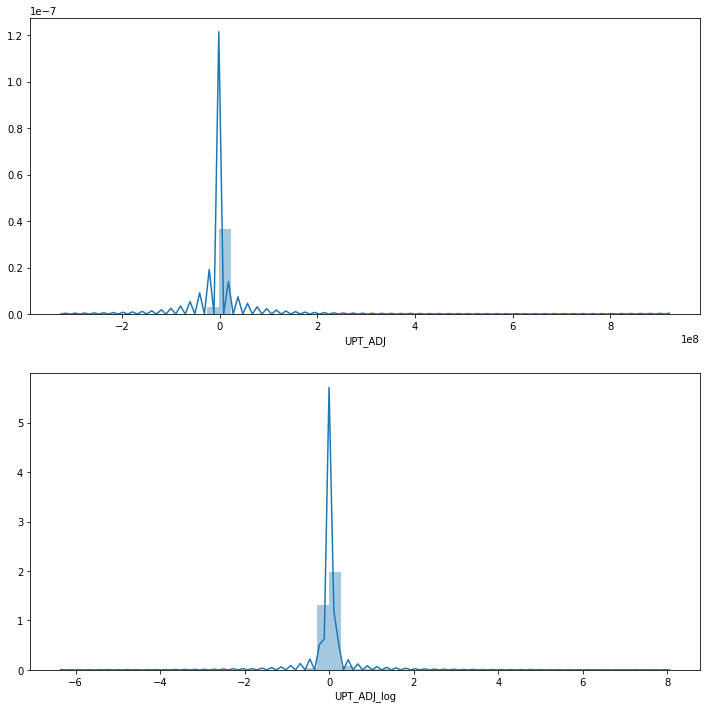

In [16]:
var = 'UPT_ADJ'

# below is generic
f, axes = plt.subplots(2, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(df[var], label='First Diff', ax=axes[0])
sns.distplot(df[var+'_log'], label='First Diff of Log', ax=axes[1])

plt.show()

Excluding 263 records with missing values.


/Users/rianajawad/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/rianajawad/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/rianajawad/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


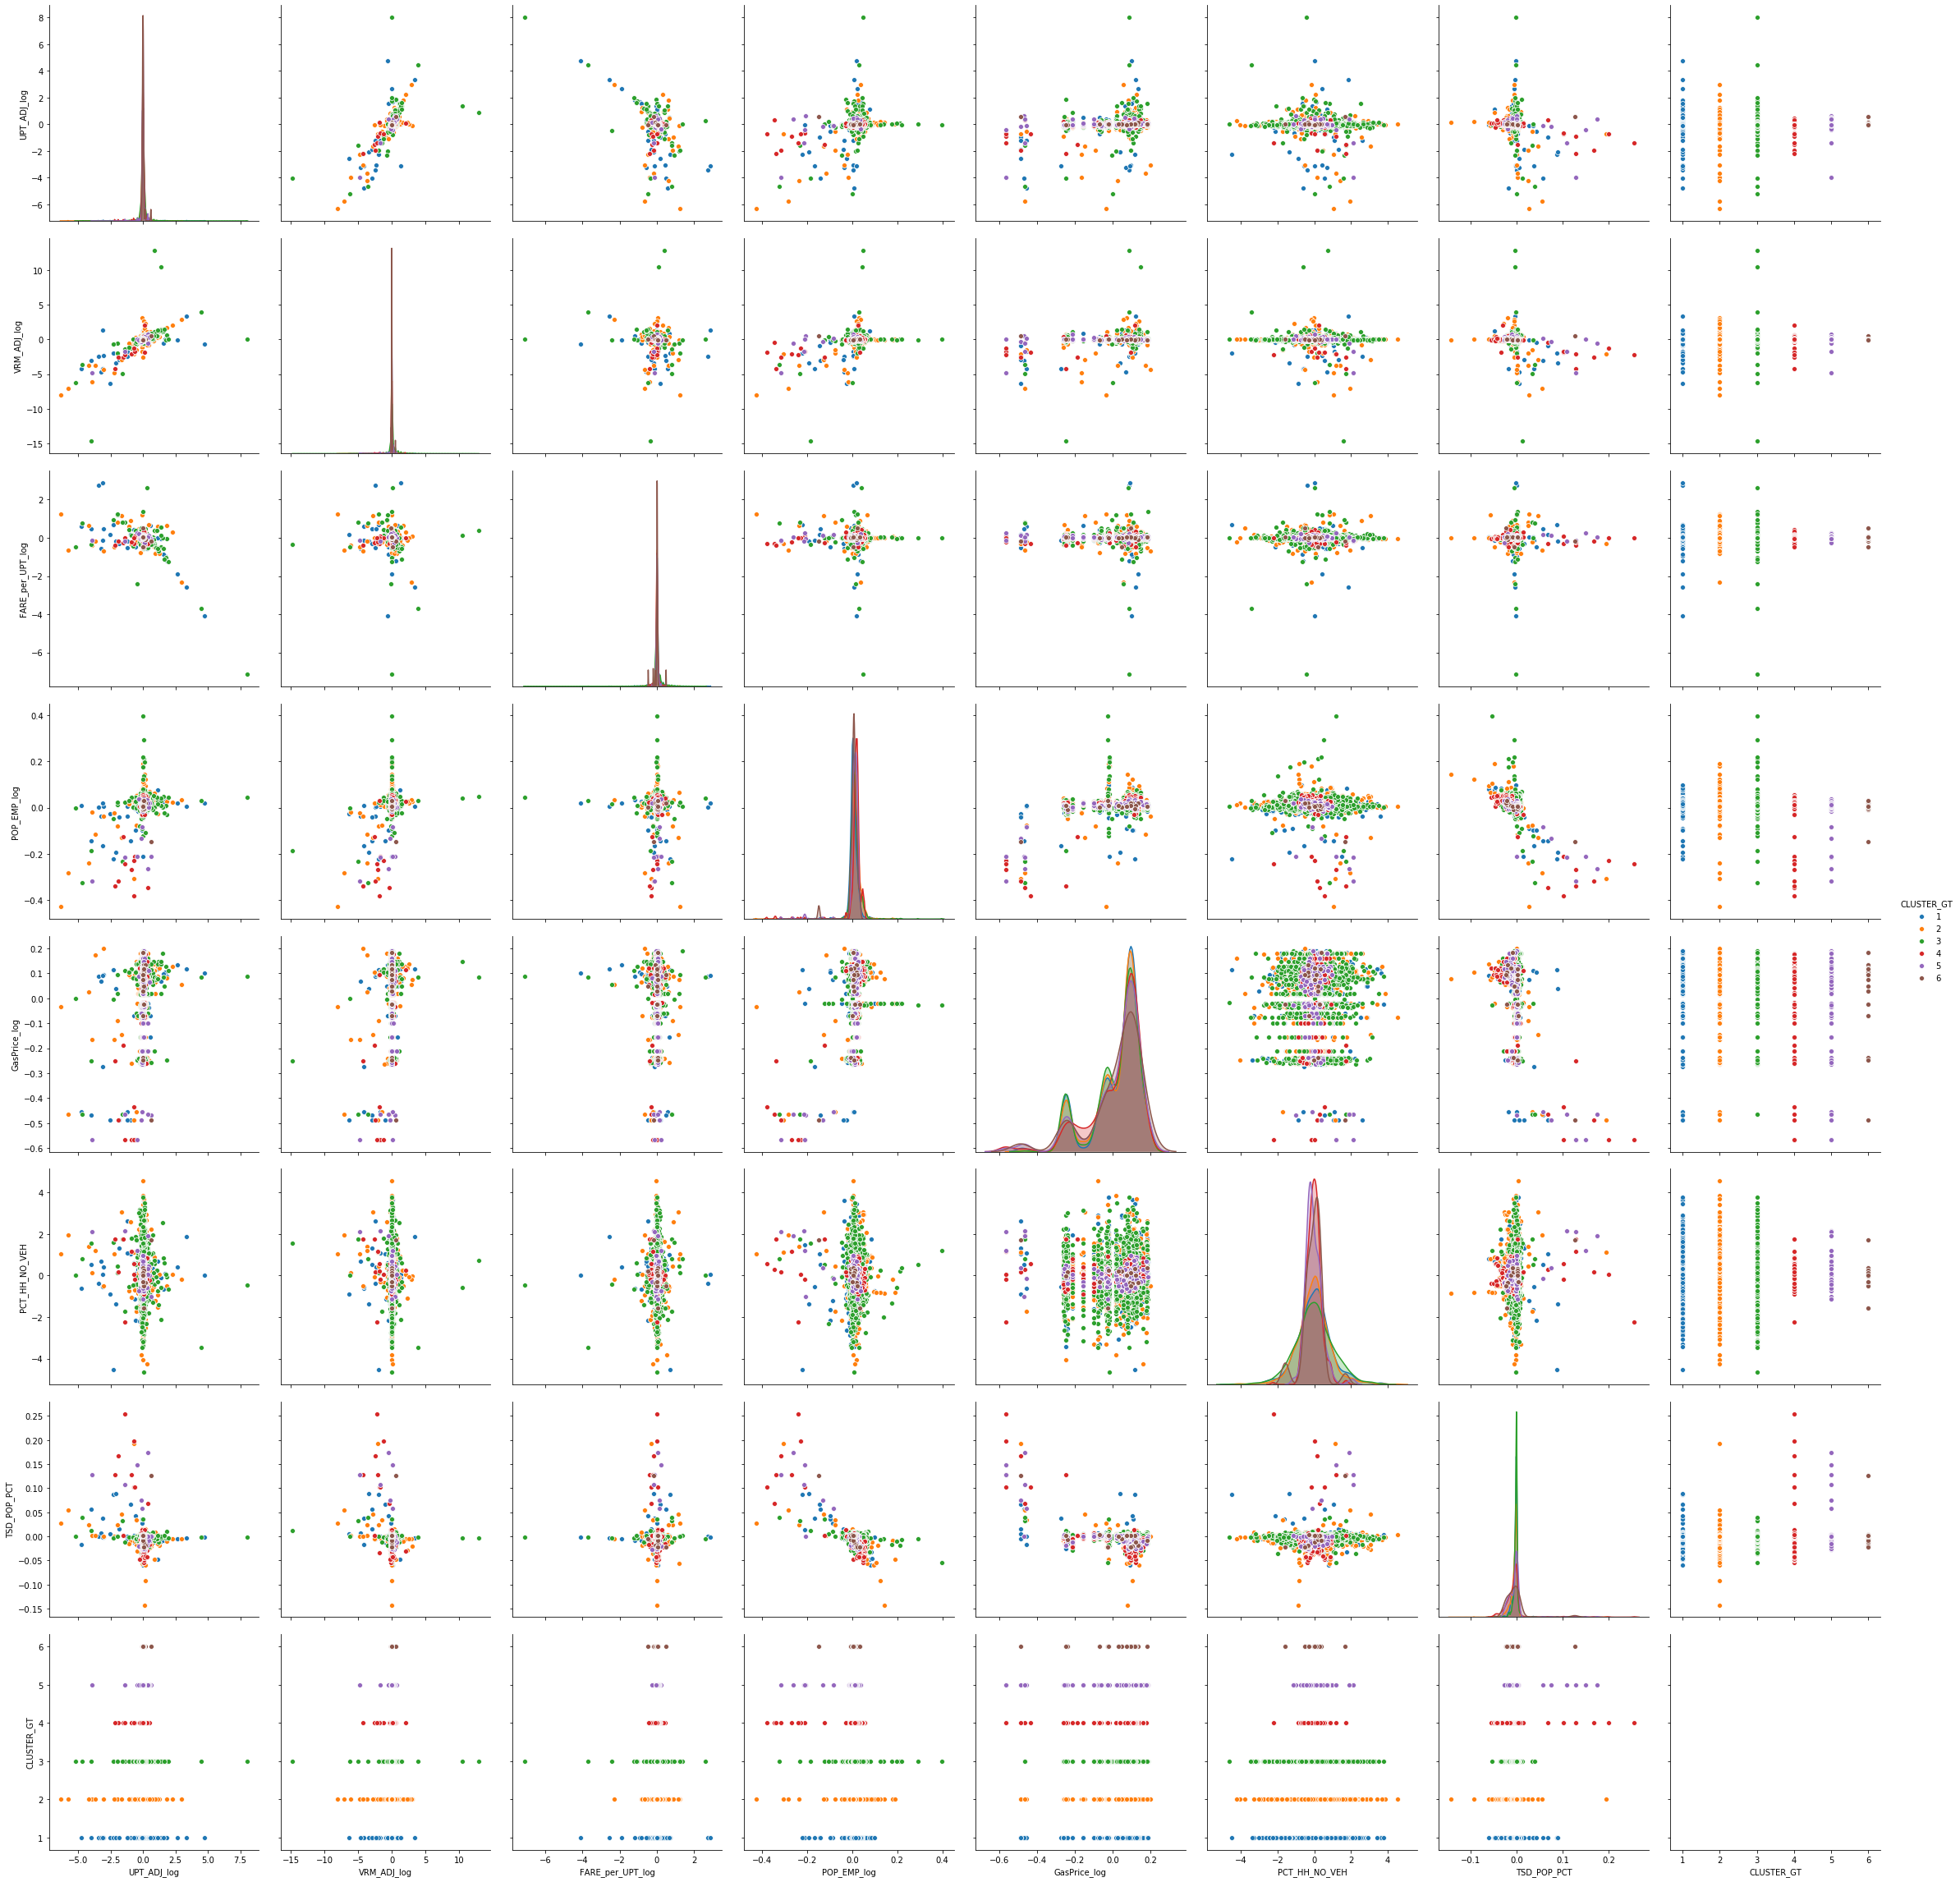

In [17]:
# look at some pair plots

df2 = df[['UPT_ADJ_log', 
         'VRM_ADJ_log', 
         'FARE_per_UPT_log', 
         'POP_EMP_log', 
         'GasPrice_log', 
         'PCT_HH_NO_VEH', 
         'TSD_POP_PCT', 
         'CLUSTER_GT']]

# check for missing data
df2 = df2.replace([np.inf, -np.inf], np.nan)
df2 = df2.dropna()
len_diff = len(df) - len(df2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(df2, hue=('CLUSTER_GT'), diag_kind='kde', dropna=True, size=4)
plt.savefig('pairplot_model.png')


In [18]:
# show the correlation matrix
df2.corr().style.background_gradient(cmap='Reds')

,UPT_ADJ_log,VRM_ADJ_log,FARE_per_UPT_log,POP_EMP_log,GasPrice_log,PCT_HH_NO_VEH,TSD_POP_PCT,CLUSTER_GT
UPT_ADJ_log,1,0.678666,-0.521288,0.388662,0.191834,-0.0451972,-0.228902,0.016916
VRM_ADJ_log,0.678666,1,-0.0860112,0.398985,0.15115,-0.0516297,-0.241278,0.0151587
FARE_per_UPT_log,-0.521288,-0.0860112,1,-0.0343141,-0.0378602,0.0148268,-0.00689164,0.00464214
POP_EMP_log,0.388662,0.398985,-0.0343141,1,0.321519,-0.0567037,-0.686591,0.0170671
GasPrice_log,0.191834,0.15115,-0.0378602,0.321519,1,0.035999,-0.327557,-0.0193484
PCT_HH_NO_VEH,-0.0451972,-0.0516297,0.0148268,-0.0567037,0.035999,1,0.0135377,-0.00538262
TSD_POP_PCT,-0.228902,-0.241278,-0.00689164,-0.686591,-0.327557,0.0135377,1,-0.0107451
CLUSTER_GT,0.016916,0.0151587,0.00464214,0.0170671,-0.0193484,-0.00538262,-0.0107451,1


Excluding 263 records with missing values.


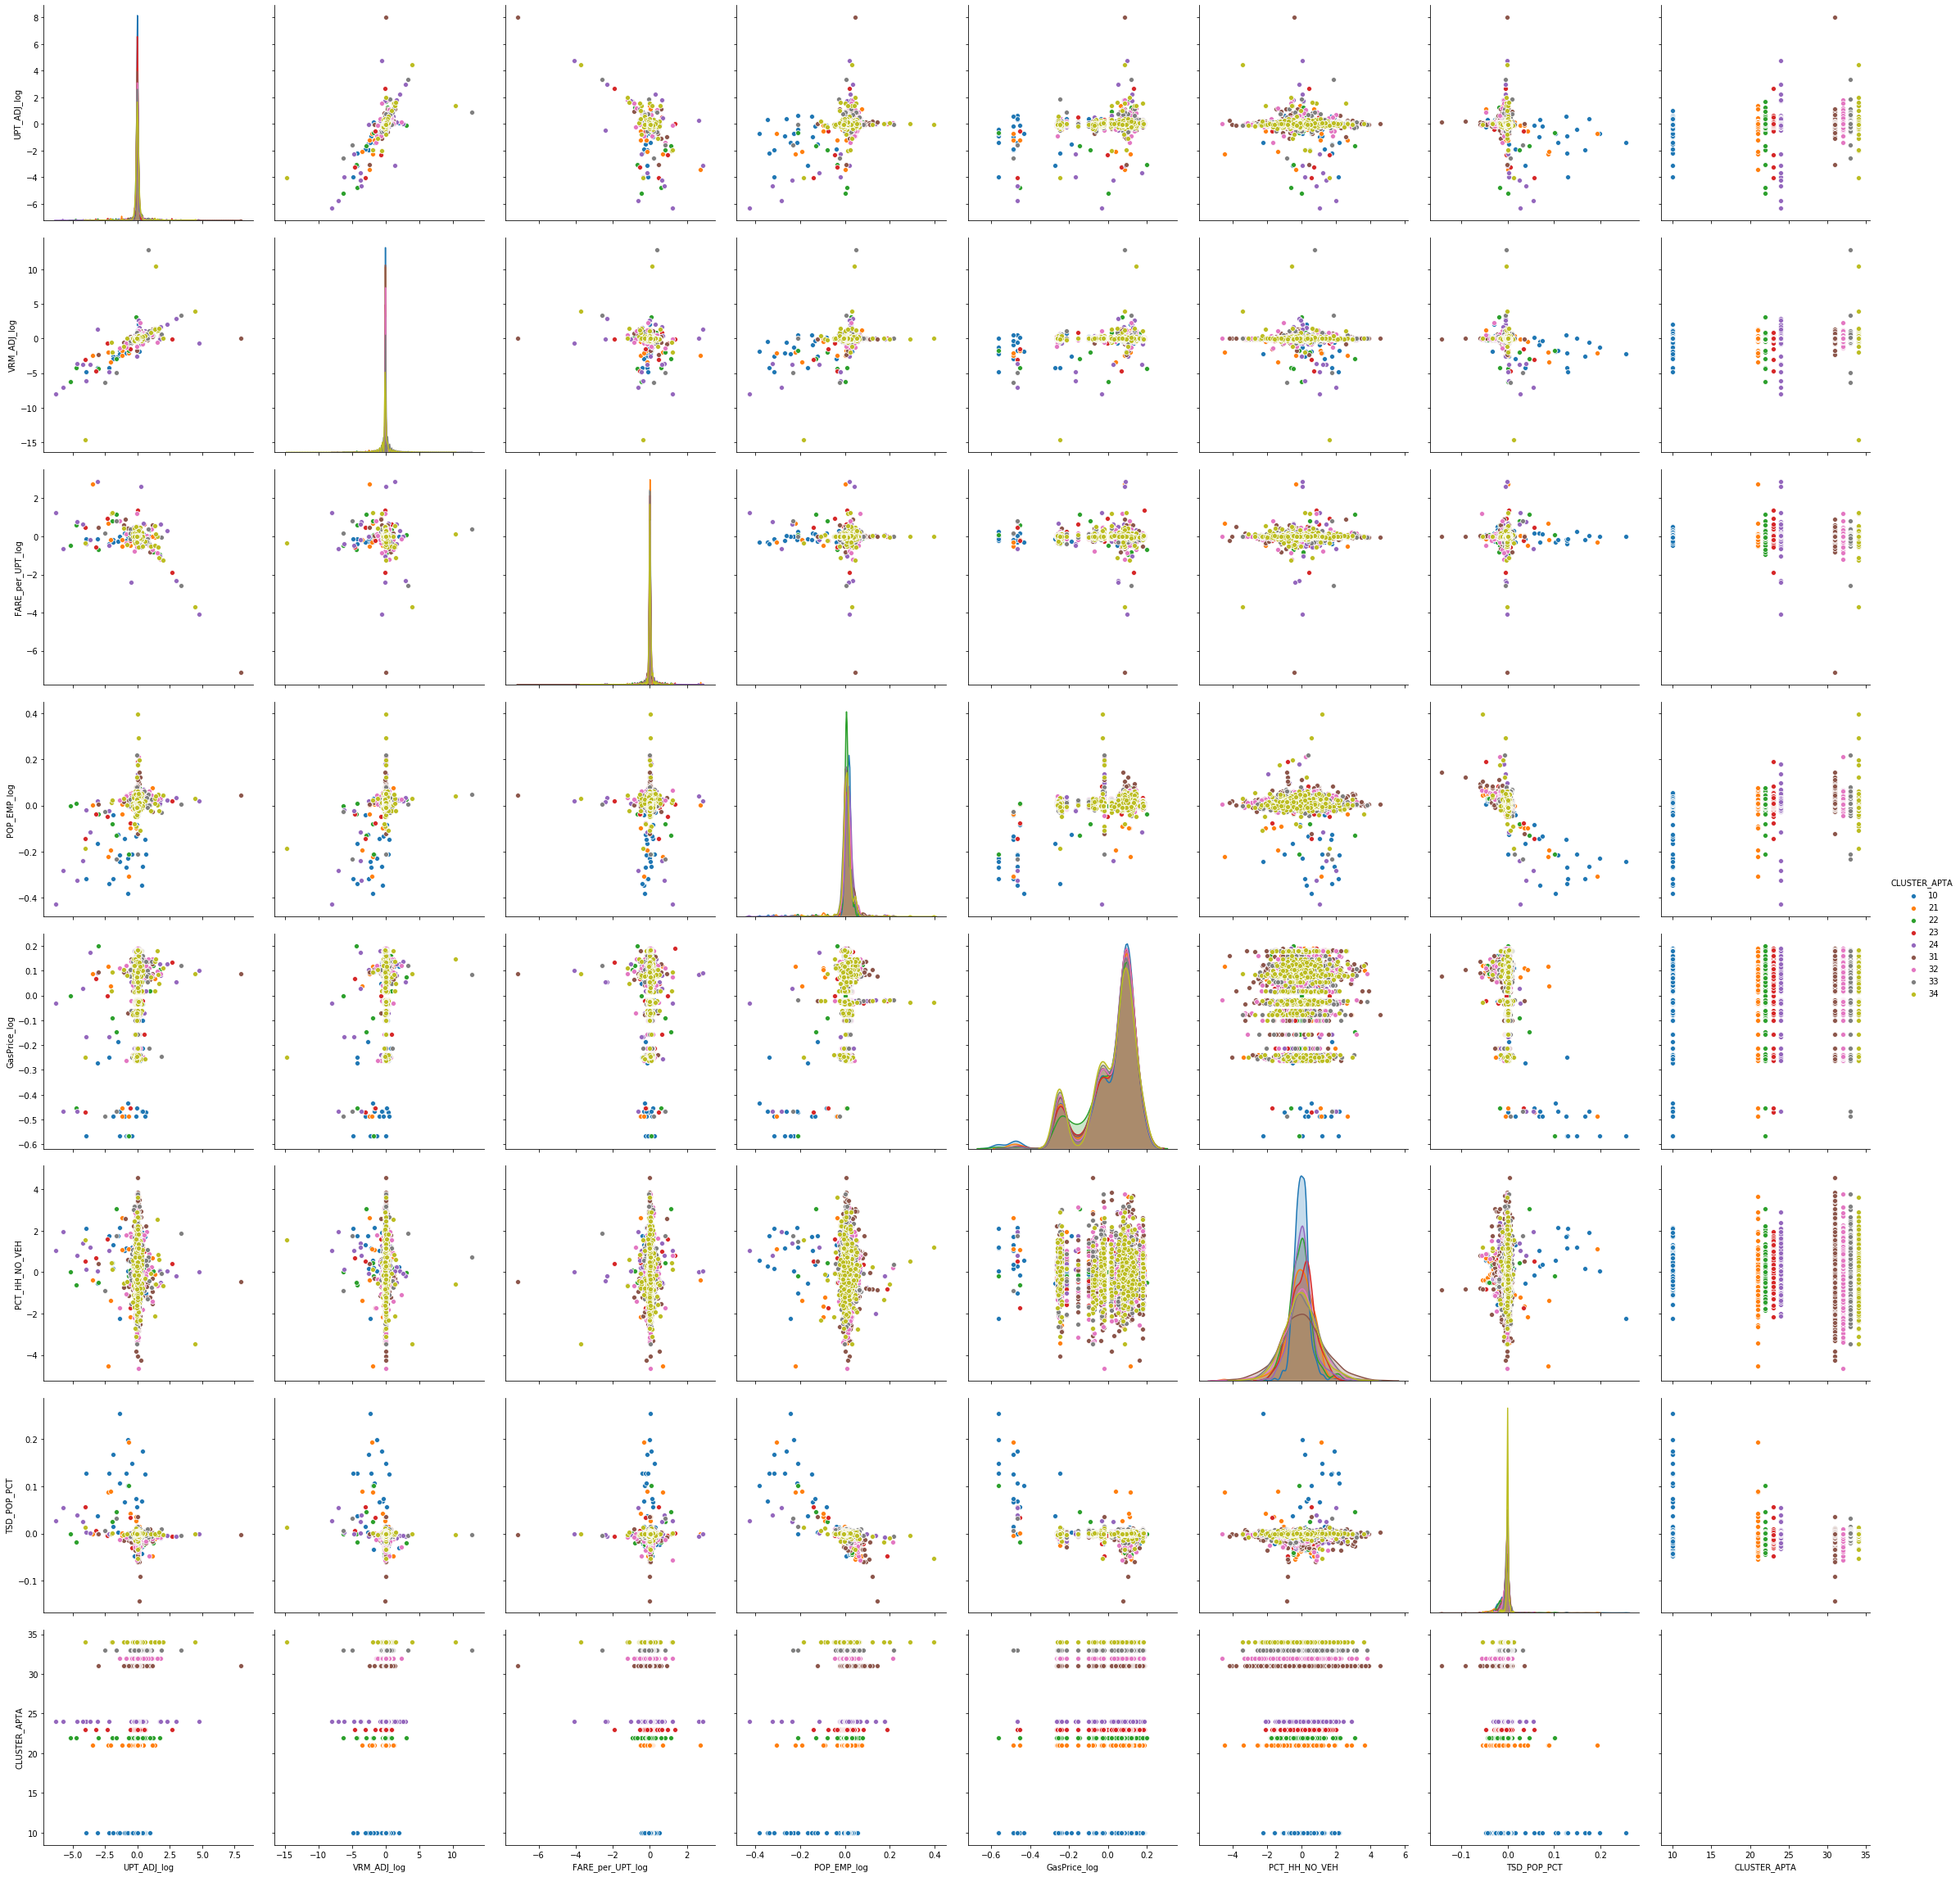

In [36]:
# look at some pair plots

df3 = df[['UPT_ADJ_log', 
         'VRM_ADJ_log', 
         'FARE_per_UPT_log', 
         'POP_EMP_log', 
         'GasPrice_log', 
         'PCT_HH_NO_VEH', 
         'TSD_POP_PCT', 
         'CLUSTER_APTA']]

# check for missing data
df3 = df3.replace([np.inf, -np.inf], np.nan)
df3 = df3.dropna()
len_diff = len(df) - len(df3)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(df3, hue=('CLUSTER_APTA'), diag_kind='kde', dropna=True, size=4)

In [37]:
# show the correlation matrix
df3.corr().style.background_gradient(cmap='Reds')

,UPT_ADJ_log,VRM_ADJ_log,FARE_per_UPT_log,POP_EMP_log,GasPrice_log,PCT_HH_NO_VEH,TSD_POP_PCT,CLUSTER_APTA
UPT_ADJ_log,1,0.678666,-0.521288,0.388662,0.191834,-0.0451972,-0.228902,0.0481665
VRM_ADJ_log,0.678666,1,-0.0860112,0.398985,0.15115,-0.0516297,-0.241278,0.0404846
FARE_per_UPT_log,-0.521288,-0.0860112,1,-0.0343141,-0.0378602,0.0148268,-0.00689164,-0.0171627
POP_EMP_log,0.388662,0.398985,-0.0343141,1,0.321519,-0.0567037,-0.686591,0.0473848
GasPrice_log,0.191834,0.15115,-0.0378602,0.321519,1,0.035999,-0.327557,0.0153494
PCT_HH_NO_VEH,-0.0451972,-0.0516297,0.0148268,-0.0567037,0.035999,1,0.0135377,0.014754
TSD_POP_PCT,-0.228902,-0.241278,-0.00689164,-0.686591,-0.327557,0.0135377,1,0.0446357
CLUSTER_APTA,0.0481665,0.0404846,-0.0171627,0.0473848,0.0153494,0.014754,0.0446357,1


Excluding 263 records with missing values.


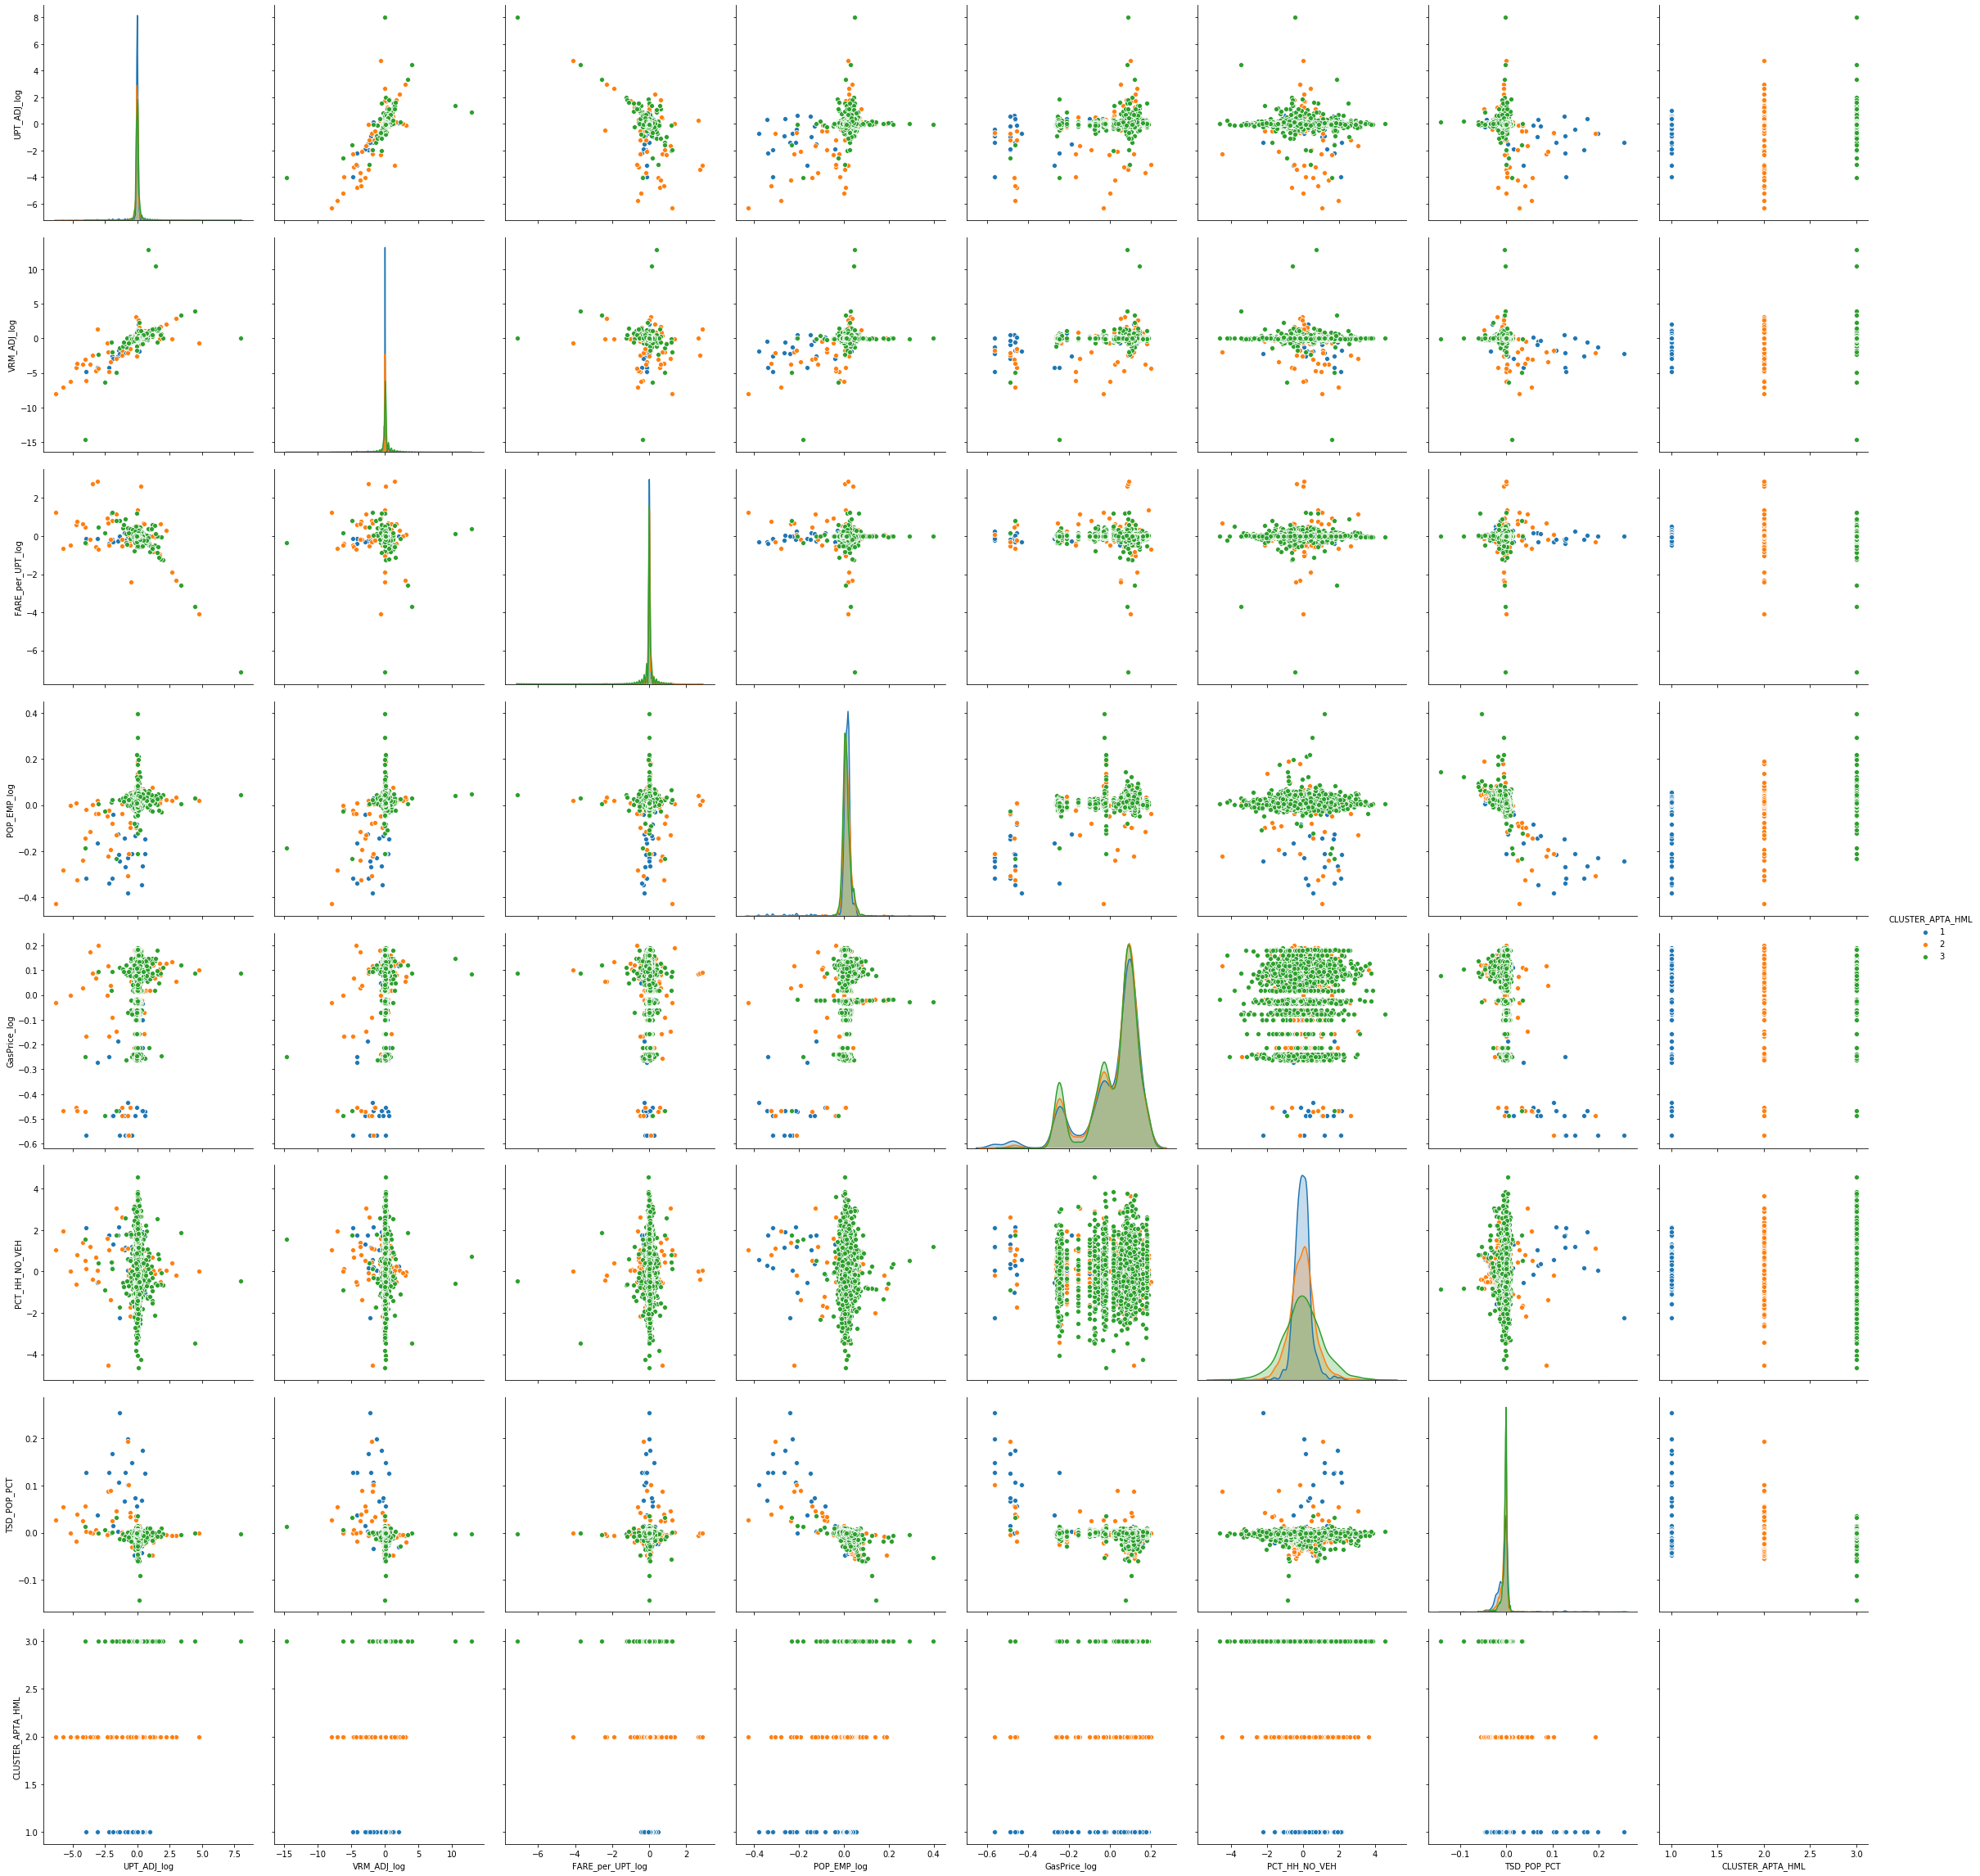

In [39]:
# look at some pair plots

df4 = df[['UPT_ADJ_log', 
         'VRM_ADJ_log', 
         'FARE_per_UPT_log', 
         'POP_EMP_log', 
         'GasPrice_log', 
         'PCT_HH_NO_VEH', 
         'TSD_POP_PCT', 
         'CLUSTER_APTA_HML']]

# check for missing data
df4 = df4.replace([np.inf, -np.inf], np.nan)
df4 = df4.dropna()
len_diff = len(df) - len(df4)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(df4, hue=('CLUSTER_APTA_HML'), diag_kind='kde', dropna=True, size=4)

In [41]:
# show the correlation matrix
df4.corr().style.background_gradient(cmap='Reds')

,UPT_ADJ_log,VRM_ADJ_log,FARE_per_UPT_log,POP_EMP_log,GasPrice_log,PCT_HH_NO_VEH,TSD_POP_PCT,CLUSTER_APTA_HML
UPT_ADJ_log,1,0.678666,-0.521288,0.388662,0.191834,-0.0451972,-0.228902,0.0520624
VRM_ADJ_log,0.678666,1,-0.0860112,0.398985,0.15115,-0.0516297,-0.241278,0.0430343
FARE_per_UPT_log,-0.521288,-0.0860112,1,-0.0343141,-0.0378602,0.0148268,-0.00689164,-0.0170018
POP_EMP_log,0.388662,0.398985,-0.0343141,1,0.321519,-0.0567037,-0.686591,0.0457181
GasPrice_log,0.191834,0.15115,-0.0378602,0.321519,1,0.035999,-0.327557,0.0150657
PCT_HH_NO_VEH,-0.0451972,-0.0516297,0.0148268,-0.0567037,0.035999,1,0.0135377,0.0153649
TSD_POP_PCT,-0.228902,-0.241278,-0.00689164,-0.686591,-0.327557,0.0135377,1,0.0361964
CLUSTER_APTA_HML,0.0520624,0.0430343,-0.0170018,0.0457181,0.0150657,0.0153649,0.0361964,1
